### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 9090786 # enter the SSID number to model as an int here, in place of xxxxxxxx
iters = 50 # enter the number of randomised search iterations here 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm

from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR

from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV

from sklearn.metrics.scorer import make_scorer
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 7.55 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(12986, 12)

time: 158 ms


In [5]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 25 unique JPIDs traversing this segment, over the course of 12986 observations.
time: 3 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 10 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 17 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(12986, 14)

time: 20 ms


In [9]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 3 ms


In [10]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 5 ms


In [11]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 33 ms


In [12]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 11 ms


In [13]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,Day,HourFrame
0,80,0.000000,17.5,38,1,0,Tuesday,11
1,41,0.000000,17.0,38,1,0,Tuesday,14
2,60,0.033333,14.5,38,1,0,Tuesday,7
3,61,0.000000,15.0,38,1,0,Tuesday,8
4,59,0.000000,14.0,38,1,0,Wednesday,7
5,119,0.000000,14.5,38,1,0,Wednesday,8
6,90,0.000000,12.5,38,1,0,Thursday,7
7,119,0.000000,9.5,38,1,0,Thursday,8
8,18,1.166667,16.0,38,1,0,Friday,7
9,137,0.566667,16.0,38,1,0,Friday,8


time: 26 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

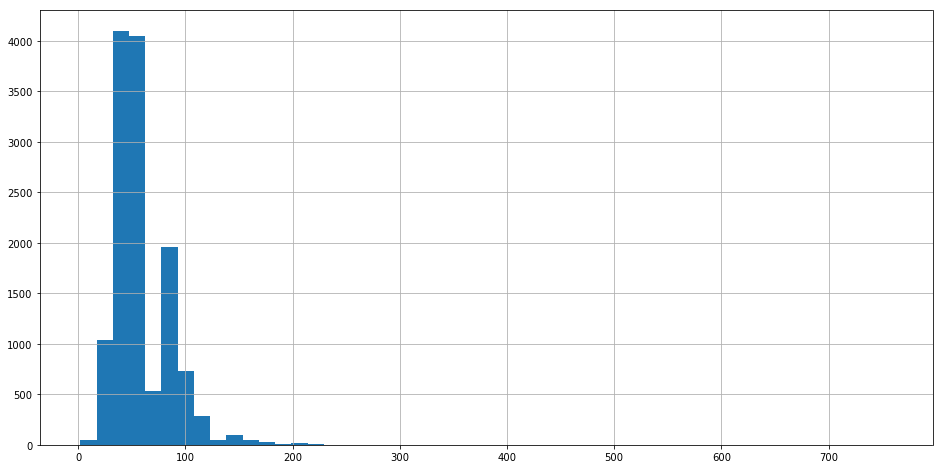

time: 235 ms


In [14]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

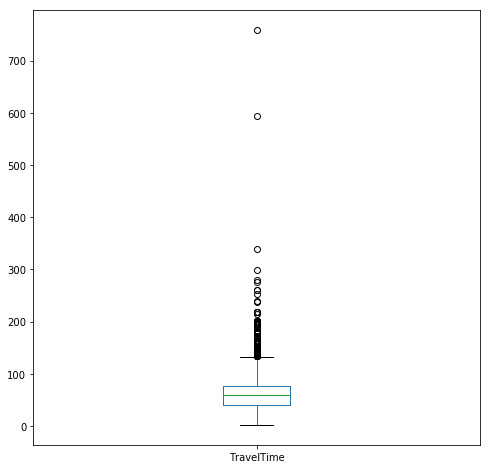

time: 180 ms


In [15]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [16]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    12986.000000
mean        59.226706
std         27.661573
min          2.000000
25%         40.000000
50%         59.000000
75%         77.000000
max        759.000000
Name: TravelTime, dtype: float64

time: 7 ms


Dropping outliers

In [17]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

14.5378563877
time: 11 ms


In [18]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 3 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (3*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

Outlier_Count = trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0]
Row_Count = Row_Count - Outlier_Count

print("There will be", Outlier_Count, "outliers dropped.")

There will be 57 outliers dropped.
time: 18 ms


In [19]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)

time: 40 ms


In [20]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    12929.000000
mean        58.774383
std         25.120712
min         15.000000
25%         40.000000
50%         59.000000
75%         77.000000
max        188.000000
Name: TravelTime, dtype: float64

time: 7 ms


#### Visualising range of data after dropping outliers

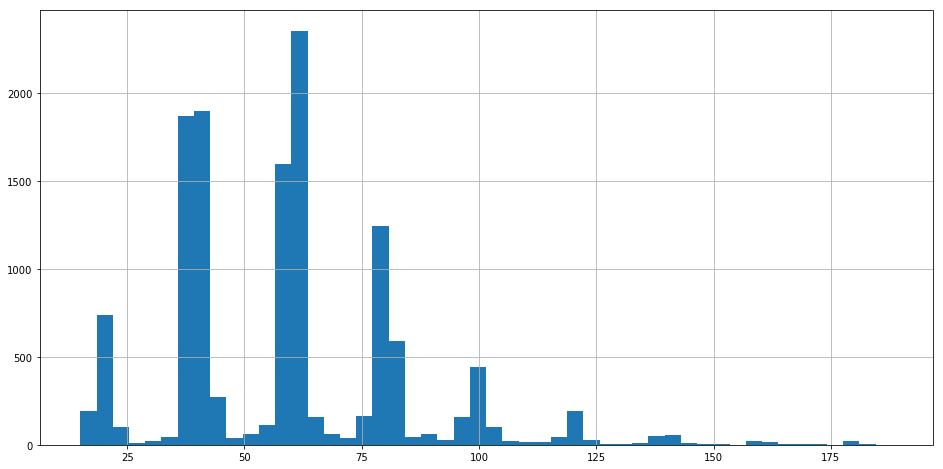

time: 205 ms


In [21]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

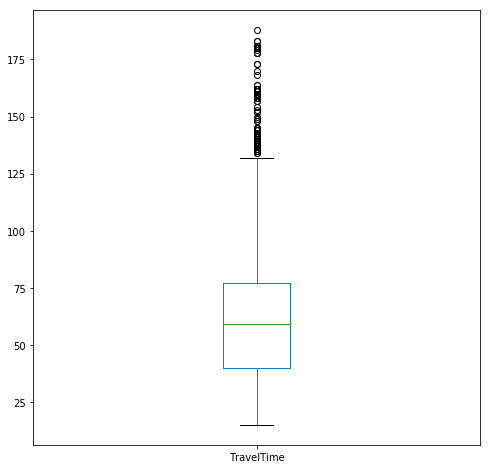

time: 179 ms


In [22]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

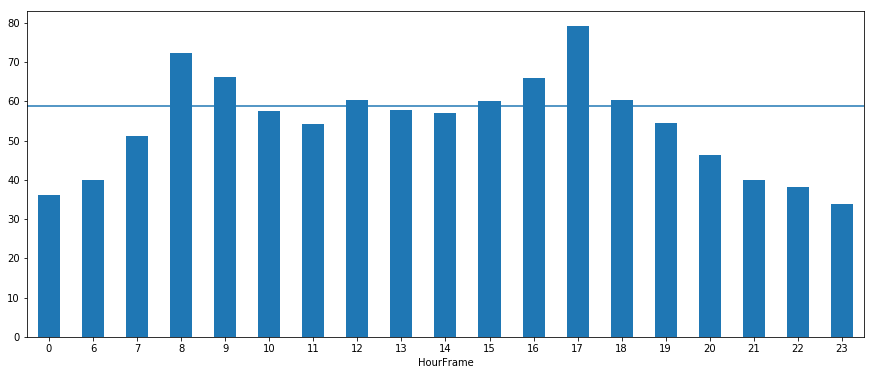

time: 188 ms


In [23]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

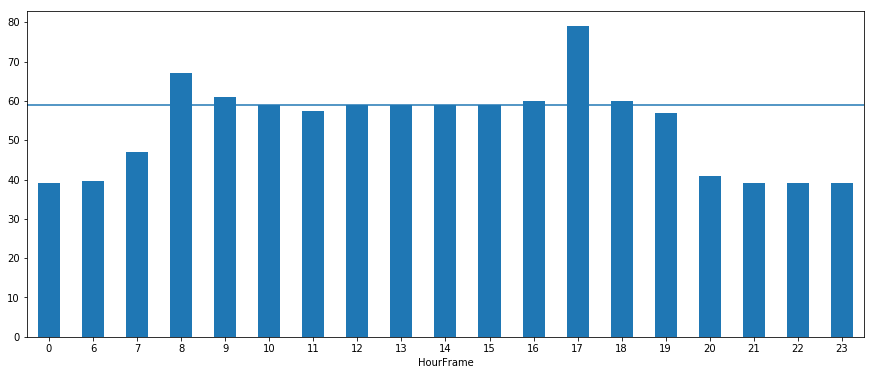

time: 185 ms


In [24]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

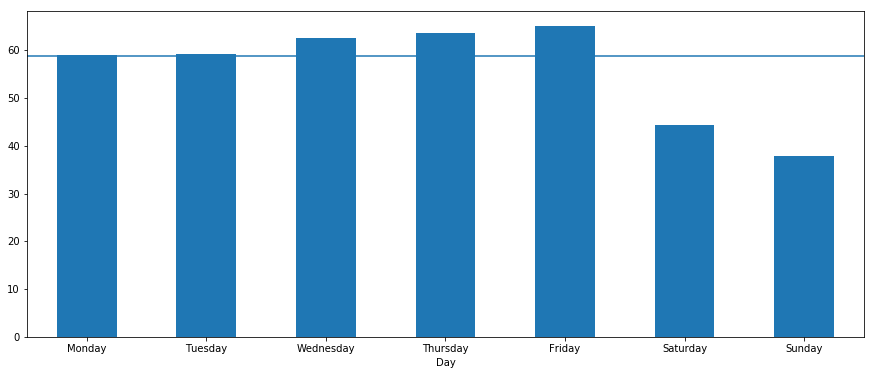

time: 144 ms


In [25]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

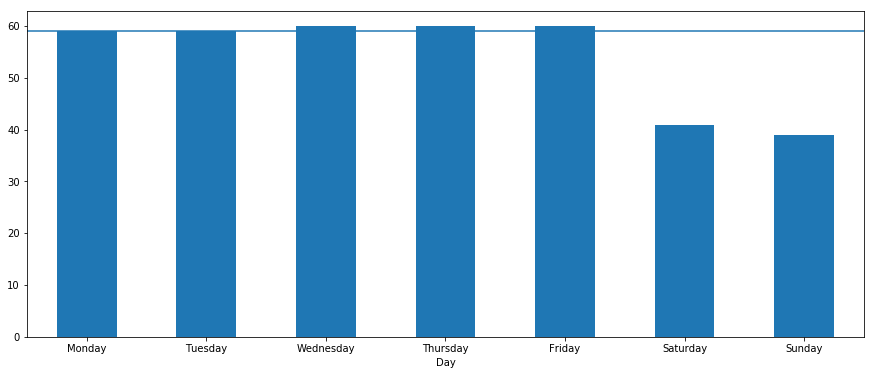

time: 144 ms


In [26]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

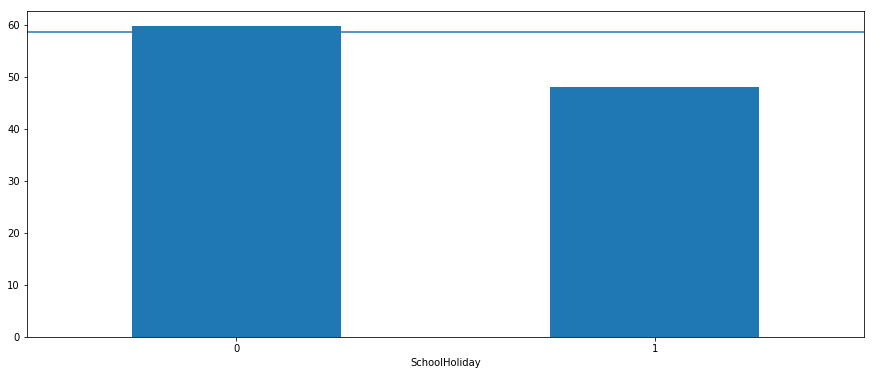

time: 161 ms


In [27]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

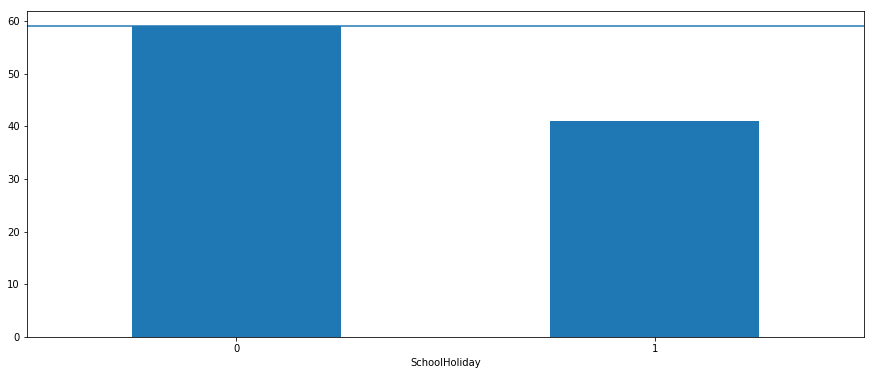

time: 125 ms


In [28]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [29]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,XBuses,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,188,0.666667,18.0,45,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,183,0.000000,14.5,71,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,183,1.866211,21.5,63,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,181,0.000000,17.5,71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,181,0.000000,6.0,63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,181,1.533203,18.5,64,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,181,0.600098,21.5,63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,180,0.000000,12.0,63,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,180,0.000000,4.0,64,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,180,0.000000,11.5,71,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


time: 53 ms


In [30]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 1 ms


In [31]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [32]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 4 ms


For comparison purposes, first train on Linear Regression

### 3.2a Linear Regression model (via scikit-learn) - training - default parameters

In [33]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 10 ms


In [34]:

lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)
print()
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))
print()
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.292684511768

The mean absolute error of the Linear Regression model is 15.7238388697
The mean absolute percentage error is 26.7528777365

The median absolute error of the Linear Regression model is 12.7039894555
The median absolute percentage error is 21.5321855179
time: 30 ms


### 3.2b Linear Regression model (via scikit-learn) - testing - default parameters

In [35]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)
print()
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))
print()
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.294873356305

The mean absolute error of the Linear Regression model is 15.8136376694
The mean absolute percentage error is 26.9056633462

The median absolute error of the Linear Regression model is 12.647643851
The median absolute percentage error is 21.4366844931
time: 9 ms


### 3.3a Gradient Boosting Regression model - training - default parameters

In [36]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 419 ms


In [37]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
Day_Sunday 	 0.093448481578
Day_Saturday 	 0.0911492304546
Rain 	 0.0743958582784
HF_23 	 0.060401944665
SchoolHoliday 	 0.0580189679653
WindSpeed 	 0.057646317409
HF_17 	 0.0562528186833
HF_22 	 0.0547150055311
HF_21 	 0.054651959331
HF_6 	 0.0471654325726
HF_20 	 0.0456660271651
HF_7 	 0.0381598315541
HF_8 	 0.0339076149594
HF_9 	 0.0336153405193
Day_Tuesday 	 0.0328909070272
Day_Monday 	 0.0296688595214
JPID_length 	 0.0245992772807
HF_11 	 0.0225626272634
HF_16 	 0.0220725755824
HF_19 	 0.018219518038
HF_15 	 0.0118794233575
Day_Thursday 	 0.0103201781191
XBuses 	 0.0101389301876
HF_18 	 0.00521431651511
Day_Wednesday 	 0.00508350958751
HF_10 	 0.0045521262674
HF_14 	 0.00177225149017
HF_12 	 0.00174178972662
HF_13 	 8.88793698148e-05
time: 69 ms


In [38]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.324917471212

The mean absolute error of the trained Gradient Boosting Regression model is 15.1876001379
The mean absolute percentage error is 25.8405096215

The median absolute error of the trained Gradient Boosting Regression model is 12.1147956836
The median absolute percentage error is 20.5335520061
time: 20 ms


### 3.3b Gradient Boosting Regression model - - testing - default parameters

In [39]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.30868235955

The mean absolute error of the trained Gradient Boosting Regression model is 15.5690695386
The mean absolute percentage error is 26.4895498667

The median absolute error of the trained Gradient Boosting Regression model is 12.4911169461
The median absolute percentage error is 21.1713846544
time: 14 ms


### 3.4a Gradient Boosting Regression model - training - LAD loss function 

In [40]:
gbr = GBR(loss='lad')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 482 ms


In [41]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
Day_Sunday 	 0.17228131628
HF_23 	 0.105462826114
Day_Saturday 	 0.0955354110012
HF_21 	 0.0925094444935
HF_22 	 0.0795502884056
HF_6 	 0.0670791925106
HF_20 	 0.0610443386024
HF_17 	 0.0591955548654
SchoolHoliday 	 0.0546327018645
Rain 	 0.0432632335993
HF_19 	 0.0279283509478
WindSpeed 	 0.0213910462244
HF_11 	 0.0189339581996
HF_8 	 0.0155395908557
HF_7 	 0.0152967261382
JPID_length 	 0.0152747018552
Day_Monday 	 0.0138392315263
HF_16 	 0.0137171752061
HF_9 	 0.0131542158724
Day_Tuesday 	 0.00715077205718
Day_Wednesday 	 0.00275188039946
HF_13 	 0.002478092347
Day_Thursday 	 0.00123283376961
XBuses 	 0.000665781790444
HF_14 	 9.13350749565e-05
HF_10 	 0.0
HF_12 	 0.0
HF_18 	 0.0
HF_15 	 0.0
time: 68 ms


In [42]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.253311644193

The mean absolute error of the trained Gradient Boosting Regression model is 14.9491024461
The mean absolute percentage error is 25.4347245176

The median absolute error of the trained Gradient Boosting Regression model is 16.212721045
The median absolute percentage error is 27.4791882119
time: 19 ms


### 3.4b Gradient Boosting Regression model - testing - LAD loss function 

In [43]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.253601219358

The mean absolute error of the trained Gradient Boosting Regression model is 15.2434140961
The mean absolute percentage error is 25.9354726908

The median absolute error of the trained Gradient Boosting Regression model is 16.3730103807
The median absolute percentage error is 27.750865052
time: 15 ms


### 3.5a Gradient Boosting Regression model - training - HUBER loss function 

In [44]:
gbr = GBR(loss='huber')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

time: 595 ms


In [45]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
Day_Sunday 	 0.103487470059
Day_Saturday 	 0.0864230461837
HF_23 	 0.0671385510054
HF_21 	 0.060112791881
HF_22 	 0.0597148178233
SchoolHoliday 	 0.0554982482214
HF_17 	 0.0553628697419
HF_20 	 0.049247882245
HF_6 	 0.0490620010026
WindSpeed 	 0.0485098120869
Rain 	 0.046770074558
HF_7 	 0.0434978149336
JPID_length 	 0.0372398540354
HF_8 	 0.0359978730727
Day_Tuesday 	 0.0315682260839
Day_Monday 	 0.0299063535035
HF_19 	 0.0293344780048
HF_9 	 0.0277666076635
HF_16 	 0.0233708274662
HF_11 	 0.0225785593403
Day_Thursday 	 0.0120874716469
HF_15 	 0.00552694087274
HF_14 	 0.00508902452134
Day_Wednesday 	 0.0034418545002
HF_13 	 0.00296849790635
HF_10 	 0.00273019011032
XBuses 	 0.00253047121166
HF_18 	 0.00154635251107
HF_12 	 0.00149103780743
time: 69 ms


In [46]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.313594638827

The mean absolute error of the trained Gradient Boosting Regression model is 15.0411771158
The mean absolute percentage error is 25.5913823416

The median absolute error of the trained Gradient Boosting Regression model is 12.1510398958
The median absolute percentage error is 20.5949828742
time: 19 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [47]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.29914346469

The mean absolute error of the trained Gradient Boosting Regression model is 15.4492724127
The mean absolute percentage error is 26.2857244595

The median absolute error of the trained Gradient Boosting Regression model is 12.55838616
The median absolute percentage error is 21.2854002712
time: 16 ms


## 4 Parameter tuning with RandomizedSearchCV

In [48]:
print("Note that there are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

Note that there are 25 unique JPIDs traversing this segment, over the course of 12929 observations.
time: 1e+03 µs


In [49]:
STOP HERE - from results above, select best loss function for each of the three trainings below,

SyntaxError: invalid syntax (<ipython-input-49-df044ab76723>, line 1)

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

##### Train with Median Absolute Error as scorer

In [50]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 6 ms


In [51]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002790D9B0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002790DF28>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002790D518>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000279201D0>, 'learning_rate': <scipy.stats._distn_inf

time: 10min 9s


In [52]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.11682671971553266, 'max_depth': 7, 'min_samples_leaf': 53, 'min_samples_split': 676, 'n_estimators': 101}
time: 1e+03 µs


In [53]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 11.9077466326
Best MdAPE found is 20.183%
time: 4 ms


In [54]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-11.566355,-11.907747,101,7,53,676,0.116827,1.0210,0.0050
1,2,-11.308895,-11.944282,642,5,67,676,0.11815,4.9430,0.0204
2,3,-11.146217,-11.991675,558,4,30,233,0.162803,3.5658,0.0148
3,4,-11.185701,-12.001258,1032,6,36,589,0.0580396,9.0328,0.0372
4,5,-11.316173,-12.004738,1268,4,50,886,0.210486,7.2246,0.0312
5,6,-11.694414,-12.006174,443,9,72,725,0.0181516,5.1936,0.0232
6,7,-11.478523,-12.016291,755,7,29,691,0.0206213,7.4632,0.0314
7,8,-11.023683,-12.022100,237,7,18,363,0.143042,2.6728,0.0108
8,9,-11.360881,-12.034064,1022,4,53,748,0.202295,5.9376,0.0252
9,10,-11.068839,-12.060356,701,5,13,384,0.106023,5.5382,0.0228


time: 39 ms


In [55]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.314038909288

Mean absolute error of best model on the test set is 15.4059054656
Mean absolute percentage error of best model on the test set is 26.112%

Median absolute error of best model on the test set is 12.2142450001
Median absolute percentage error of best model on the test set is 20.702%
time: 21 ms


##### Train with Mean Absolute Error as scorer

In [56]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 5 ms


In [57]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.mean_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000278D0828>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000066421D0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000066424E0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006642358>, 'learning_rate': <scipy.stats._distn_inf

time: 9min 33s


In [58]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.10502613825969595, 'max_depth': 7, 'min_samples_leaf': 24, 'min_samples_split': 917, 'n_estimators': 92}
time: 1e+03 µs


In [59]:
gbr_train_MAE = abs(gbr_rsearch.best_score_)
gbr_train_MAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best Mean absolute error found is", gbr_train_MAE)
print ("Best Mean absolute percentage error found is", str(round(gbr_train_MAPE, 3)) + "%")

Best Mean absolute error found is 15.3007042197
Best Mean absolute percentage error found is 20.183%
time: 5 ms


In [60]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-14.985314,-15.300704,92,7,24,917,0.105026,0.8536,0.0046
1,2,-14.668872,-15.332678,163,8,23,942,0.145134,1.7744,0.0080
2,3,-14.582144,-15.349712,583,9,66,480,0.0343766,7.6172,0.0350
3,4,-14.989943,-15.351206,225,5,21,841,0.0762422,1.6156,0.0072
4,5,-14.667345,-15.360671,645,3,24,350,0.166056,3.1626,0.0132
5,6,-14.694742,-15.365752,105,7,58,640,0.228247,1.1166,0.0050
6,7,-14.507245,-15.373118,667,8,64,680,0.0522348,7.6724,0.0316
7,8,-14.973596,-15.379405,200,3,6,594,0.168425,0.9448,0.0044
8,9,-14.481887,-15.384384,723,7,70,457,0.0598544,7.5474,0.0316
9,10,-15.007094,-15.385281,221,4,54,672,0.108337,1.3488,0.0062


time: 39 ms


In [61]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.309247355158

Mean absolute error of best model on the test set is 15.4242902032
Mean absolute percentage error of best model on the test set is 26.143%

Median absolute error of best model on the test set is 12.2297033427
Median absolute percentage error of best model on the test set is 20.728%
time: 20 ms


##### Train with R-squared value as scorer

In [62]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 4 ms


In [63]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.r2_score))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=50, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006664080>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006664470>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006664710>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000006664898>, 'learning_rate': <scipy.stats._distn_inf

time: 10min 16s


In [64]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.069453092518023771, 'max_depth': 9, 'min_samples_leaf': 8, 'min_samples_split': 701, 'n_estimators': 167}
time: 1e+03 µs


In [65]:
gbr_train_rsqa = abs(gbr_rsearch.best_score_)

print("Best R-squared value found is", gbr_train_rsqa)

Best R-squared value found is 0.306745054671
time: 4 ms


In [66]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,0.350723,0.306745,167,9,8,701,0.0694531,2.0432,0.0092
1,2,0.382057,0.305789,417,7,54,888,0.175051,4.0670,0.0172
2,3,0.381022,0.305014,920,4,7,421,0.134954,5.7208,0.0238
3,4,0.332957,0.304948,170,9,58,875,0.0475039,1.9712,0.0090
4,5,0.371494,0.304882,559,4,18,561,0.307463,3.2870,0.0140
5,6,0.358950,0.304059,127,6,29,598,0.228478,1.1108,0.0054
6,7,0.343415,0.303690,1430,4,36,526,0.0342038,8.4196,0.0352
7,8,0.360956,0.302385,237,5,72,944,0.299377,1.7556,0.0088
8,9,0.376945,0.302323,1443,5,8,956,0.140199,10.0302,0.0412
9,10,0.415136,0.302230,993,7,46,518,0.159108,9.8426,0.0422


time: 39 ms


In [67]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.315384939621

Mean absolute error of best model on the test set is 15.383981725
Mean absolute percentage error of best model on the test set is 26.075%

Median absolute error of best model on the test set is 12.1156844004
Median absolute percentage error of best model on the test set is 20.535%
time: 31 ms


Trying new parameters

In [68]:
gbr = GBR(loss='huber', min_samples_split = int(Row_Count/100), min_samples_leaf=int(Row_Count/200), 
          learning_rate=0.1, n_estimators=300, max_depth=6, subsample=0.8)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=64,
             min_samples_split=129, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

time: 4.59 s


In [69]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.344473005145
JPID_length 	 0.153816183063
Rain 	 0.114183513323
HF_8 	 0.0273237768307
Day_Thursday 	 0.0270456350163
HF_17 	 0.0265568145448
Day_Wednesday 	 0.0232890227441
Day_Sunday 	 0.0230256942926
Day_Tuesday 	 0.021719708228
SchoolHoliday 	 0.0205699922388
Day_Saturday 	 0.0197678815928
Day_Monday 	 0.0183102901763
HF_9 	 0.0144924722066
HF_7 	 0.0136064350024
HF_16 	 0.0134764315755
HF_23 	 0.0124083675144
HF_11 	 0.0122851826153
HF_21 	 0.0113825203461
HF_18 	 0.011375833494
XBuses 	 0.0108305909577
HF_19 	 0.0107105103161
HF_14 	 0.0105834976004
HF_22 	 0.0104441254336
HF_6 	 0.0104260002536
HF_20 	 0.0102628529896
HF_15 	 0.00943744753643
HF_12 	 0.00928274454678
HF_13 	 0.0050439274858
HF_10 	 0.00386954293031
time: 187 ms


In [70]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.386195264215

The mean absolute error of the trained Gradient Boosting Regression model is 14.3390670838
The mean absolute percentage error is 24.3967972278

The median absolute error of the trained Gradient Boosting Regression model is 11.2904897153
The median absolute percentage error is 19.1364232462
time: 76 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [71]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.316888838233

The mean absolute error of the trained Gradient Boosting Regression model is 15.4762281615
The mean absolute percentage error is 26.3315875504

The median absolute error of the trained Gradient Boosting Regression model is 12.3895604017
The median absolute percentage error is 20.9992549182
time: 37 ms
